In [1]:
import sys; sys.path.append('../../')
from definitions import *
from notebooks.nb_imports import *

In [2]:
from sklearn.metrics import confusion_matrix
from src.models.optimizers import ThresholdOptimizer

/Users/jambo/miniconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
# Load raw
labels_binary = load_pickle(ROOT_DIR + '/data/processed/labels/original.pickle')
labels_utility = load_pickle(ROOT_DIR + '/data/processed/labels/utility_scores.pickle')
labels = labels_binary.reset_index()
ids_eventual = load_pickle(ROOT_DIR + '/data/processed/labels/ids_eventual.pickle')

# Drop time and mark 
labels_eventual = pd.Series(index=labels_binary.index.get_level_values('id').unique(), data=0)
labels_eventual.loc[ids_eventual] = 1

# Load preds
probas = load_pickle(ROOT_DIR + '/models/experiments/main/finalised/1/probas.pickle')

In [4]:
# Resetting the index will make some calculations easier
probas = probas.reset_index()

# Using Binary Predictions
Here we want to know, if we use the binary predictions how many people do we get correct. 

In [5]:
# Get the threshold with max score
t, s = ThresholdOptimizer(budget=500, jupyter=True).optimize(labels_binary, probas[0])

In [6]:
# Find out who is predicted yes and the first time of prediction
proba_exceed = probas[probas[0] > 0.029]  # The probas that exceed the threshold

In [7]:
# ROC the max
max_probas = probas.groupby('id').apply(max)

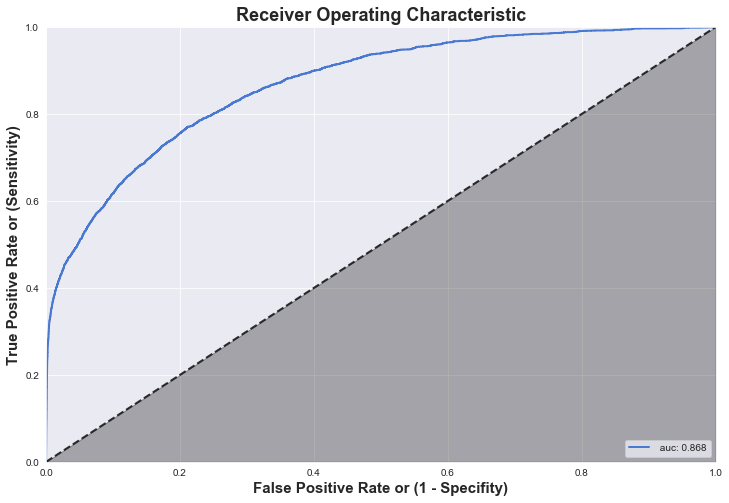

In [8]:
# Plot the ROC 
fig, ax = plt.subplots(figsize=(12, 8))
plot_roc_curves(labels_eventual, max_probas[0], ax=ax)
plt.savefig('./figures/roc.png', dpi=300, bbox_inches='tight')

In [43]:
proba_exceed = probas[probas[0] > 0.0631]  # The probas that exceed the threshold

In [44]:
# Get the predicted ids and plot a cm for the given threshold
ids_pred = proba_exceed['id'].unique()
overall_preds = pd.Series(index=labels_binary.index.get_level_values('id').unique(), data=0)
overall_preds.loc[ids_pred] = 1

In [45]:
from sklearn.metrics import precision_score
precision_score(labels_eventual, overall_preds)

0.3000786782061369

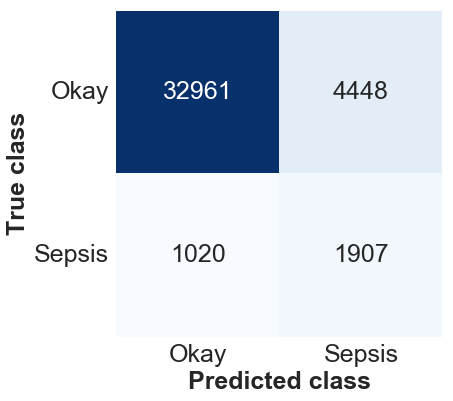

In [46]:
# Setup
fig, ax = plt.subplots(figsize=(6, 6))
classes = ['Okay', 'Sepsis']

# Plot
cm = confusion_matrix(labels_eventual, overall_preds)
df_cm = pd.DataFrame(cm, classes, classes)
sns.heatmap(df_cm, annot=True, cmap='Blues', annot_kws={"size": 25, 'fontweight': 'normal'}, cbar=False, fmt='g', ax=ax,
            linewidth=0, linecolor='black', square=True)

# Plot neatening
plt.xticks(rotation=0, fontsize=25)
plt.yticks(va='center', rotation=0, fontsize=25)
ax.set_xlabel('Predicted class', fontsize=25)
ax.set_ylabel('True class', fontsize=25)

# Save
plt.savefig('./figures/eventual_sepsis_cm.png', dpi=300, bbox_inches='tight')

In [47]:
# Below gives the ids and first time of exceed
exceed_times = proba_exceed.groupby('id', as_index=False).apply(lambda x: x.iloc[0]).set_index('id')['time']

# Find the actual time of sepsis for those with sepsis diagnosis inside the ICU (not before)
actual_times = labels[labels['SepsisLabel'] == 1].groupby('id').apply(lambda x: x.iloc[-6] if x.shape[0] > 6 else None)['time']

In [48]:
# Get the ids that were predicted correctly
ids = [x for x in actual_times.index if x in exceed_times.index]

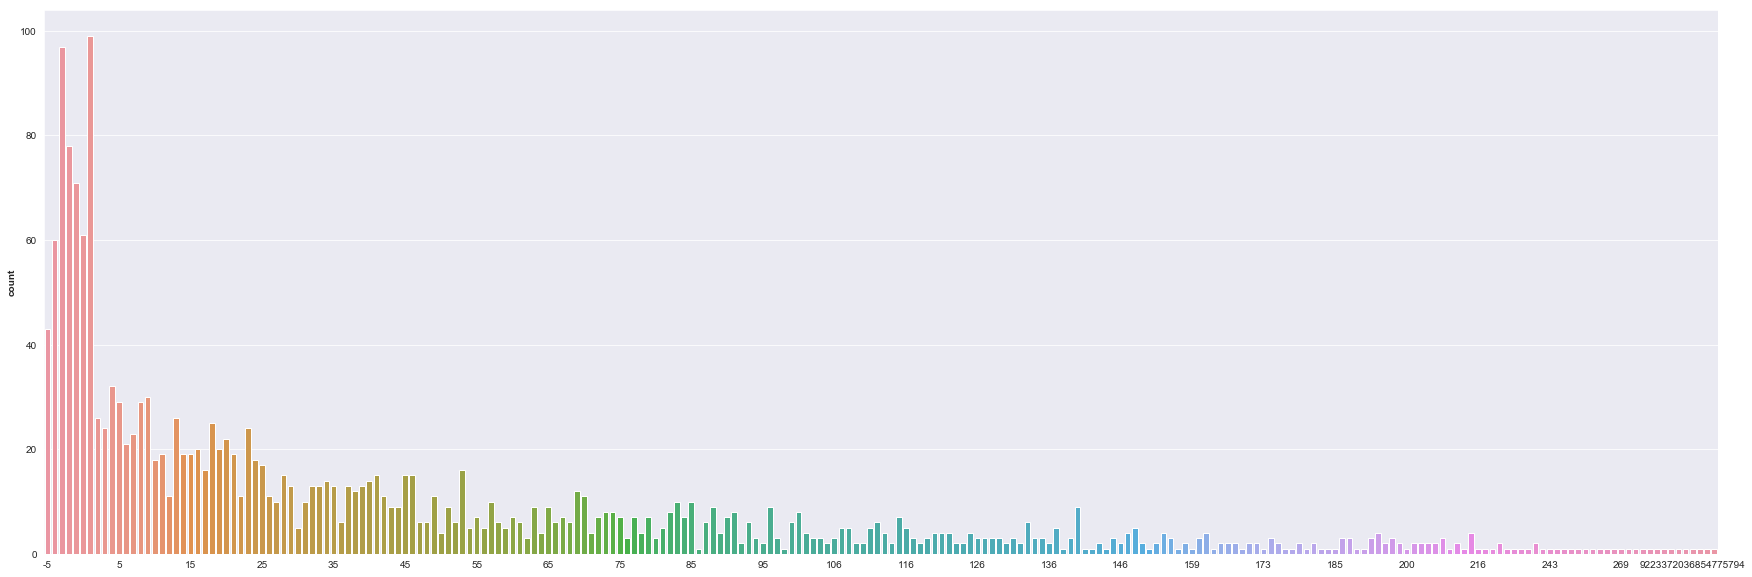

In [49]:
fig, ax = plt.subplots(figsize=(30, 10))
early_predict = actual_times.loc[ids].values.astype(int) - exceed_times.loc[ids].values.astype(int)
sns.countplot(early_predict, ax=ax)
remove_plot_ticks(ax, n=10)

In [50]:
total_num = early_predict.shape[0]
early = early_predict[early_predict >= 6].shape[0]
perfect = early_predict[(early_predict >= 0) & (early_predict < 6)].shape[0]
late = early_predict[early_predict < 0].shape[0]

pcnts = [100 * x / total_num for x in [early, perfect, late]]
print('Early: {:.1f}% \nPerfect: {:.1f}% \nLate: {:.1f}%'.format(*pcnts))

Early: 67.5% 
Perfect: 14.2% 
Late: 18.3%


In [51]:
print('This being of a total of {:.1f}% correctly labelled cases.'.format(100 * total_num / len(ids_eventual)))

This being of a total of 65.3% correctly labelled cases.


# Thresholding
Here we will evaluate the accuracy that action at a given threshold will give us

In [147]:
probas = probas.reset_index()
probas_max = probas.groupby('id').apply(max)[0]

In [148]:
print('ROC overall: {:.3f}'.format(roc_auc_score(labels_eventual, probas_max)))

ROC overall: 0.863


# Compiling Probas -> Stronger Predictor

In [21]:
from src.models.functions import cross_val_predict_to_series, CustomStratifiedGroupKFold

In [22]:
from copy import deepcopy
from xgboost import XGBRegressor
from src.models.functions import cross_val_predict_to_series, CustomStratifiedGroupKFold

In [23]:
mean_probas = probas.groupby('id').apply(lambda x: x.rolling(200, min_periods=0).mean())
std_probas = probas.groupby('id').apply(lambda x: x.rolling(200, min_periods=0).std())

In [24]:
# Make a new frame with all the proba features
proba_features = deepcopy(probas)
proba_features.set_index(['id', 'time'], inplace=True)
proba_features['mean'] = mean_probas[0].values
proba_features['std'] = std_probas[0].values

In [26]:
# Now run a second model
cv_iter = CustomStratifiedGroupKFold(n_splits=5).split(proba_features.values, labels_binary, groups=proba_features.index.get_level_values('id'))
new_pred = cross_val_predict_to_series(XGBRegressor(n_estimators=10, max_depth=3), proba_features, labels_utility, cv=cv_iter)

<function cross_val_predict_to_series at 0x123302950> 
  11123.66 ms
